In [1]:
import torch
from einops import rearrange
import numpy as np 
import torchvision
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import torch.nn.functional as F


"""
rpca_gpu
implementations of RPCA on the GPU (leveraging pytorch) 
for low-rank and sparse matrix decomposition as well as 
a nuclear-norm minimization routine via singular value 
thresholding for matrix completion
The RPCA implementation is heavily based on:
    https://github.com/dganguli/robust-pca
    
The svt implementation was based on:
    https://github.com/tonyduan/matrix-completion
References:
  [1] Candès, E. J., Li, X., Ma, Y., & Wright, J. (2011). 
      Robust principal component analysis?. Journal of the ACM (JACM), 
      58(3), 11.
  [2] Cai, J. F., Candès, E. J., & Shen, Z. (2010). 
      A singular value thresholding algorithm for matrix completion. 
      SIAM Journal on Optimization, 20(4), 1956-1982.
      
Author: Jacob Reinhold (jacob.reinhold@jhu.edu)
"""

__all__ = ['RPCA_gpu', 'svt_gpu']

class RPCA_gpu:
    """ low-rank and sparse matrix decomposition via RPCA [1] with CUDA capabilities """
    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = torch.zeros_like(self.D)
        self.Y = torch.zeros_like(self.D)
        self.mu = mu or (np.prod(self.D.shape) / (4 * self.norm_p(self.D, 2))).item()
        self.mu_inv = 1 / self.mu
        self.lmbda = lmbda or 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def norm_p(M, p):
        return torch.sum(torch.pow(M, p))

    @staticmethod
    def shrink(M, tau):
        return torch.sign(M) * F.relu(torch.abs(M) - tau)  # hack to save memory

    def svd_threshold(self, M, tau):
        U, s, V = torch.svd(M, some=True)
        return torch.mm(U, torch.mm(torch.diag(self.shrink(s, tau)), V.t()))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        i, err = 0, np.inf
        Sk, Yk, Lk = self.S, self.Y, torch.zeros_like(self.D)
        _tol = tol or 1e-7 * self.norm_p(torch.abs(self.D), 2)
        while err > _tol and i < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.norm_p(torch.abs(self.D - Lk - Sk), 2) / self.norm_p(self.D, 2)
            i += 1
            if (i % iter_print) == 0 or i == 1 or i > max_iter or err <= _tol:
                print(f'Iteration: {i}; Error: {err:0.4e}')
        self.L, self.S = Lk, Sk
        return Lk, Sk


def svt_gpu(X, mask, tau=None, delta=None, eps=1e-2, max_iter=1000, iter_print=5):
    """ matrix completion via singular value thresholding [2] with CUDA capabilties """
    Z = torch.zeros_like(X)
    tau = tau or 5 * np.sum(X.shape) / 2
    delta = delta or (1.2 * np.prod(X.shape) / torch.sum(mask)).item()
    for i in range(max_iter):
        U, s, V = torch.svd(Z, some=True)
        s = F.relu(s - tau)  # hack to save memory
        A = U @ torch.diag(s) @ V.t()
        Z += delta * mask * (X - A)
        error = (torch.norm(mask * (X - A)) / torch.norm(mask * X)).item()
        if i % iter_print == 0: print(f'Iteration: {i}; Error: {error:.4e}')
        if error < eps: break
    return A


class RPCA(torch.nn.Module):
    def __init__(self, tol=1e-15, max_iter = 500):
        super(RPCA, self).__init__()
        self.tol = tol
        self.max_iter = max_iter

    def forward(self, x):
        B,S,C,H,W = x.size()
        assert B==1

        x_flat = rearrange(x, 'b s c h w -> s (b c h w)')

        rpca = RPCA_gpu(x_flat)
        L,Sp = rpca.fit(self.tol,self.max_iter)
        L = rearrange(L, 's (b c h w) -> b s c h w', b=B,c=C,h=H,w=W, s=S)
        Sp = rearrange(Sp, 's (b c h w) -> b s c h w', b=B,c=C,h=H,w=W, s=S)
        return L, Sp

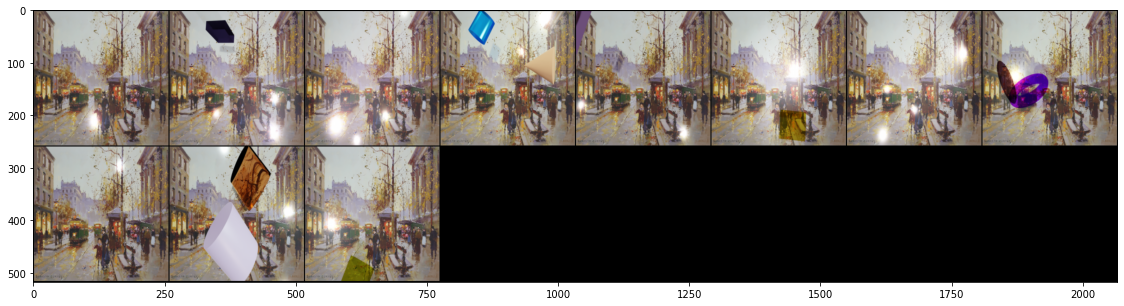

In [2]:

# read images
imgs = [read_image(f"imgs/{i}.png", torchvision.io.ImageReadMode.RGB)/255.0 for i in range(11)]
resize = torchvision.transforms.Resize((256, 256), antialias=True)
imgs = [resize(img)  for img in imgs]
imgs = torch.stack(imgs) # (B,C,H,W)

# visualize
plt.figure(figsize=(50,5))
plt.imshow(to_pil_image(make_grid(imgs)))
plt.show()

In [3]:
# RPCA behaves like a regular pytorch nn.Module and can be used with gpu input
# It expects inputs of size (1, S, C, H, W)
imgs = imgs.cuda()
rpca = RPCA(tol=1e-15, max_iter=500) 
L,Sp = rpca(imgs.unsqueeze(0))

L = L.squeeze()             # (1, S, C, H, W) -> (S, C, H, W)
Sp = Sp.squeeze()           # (1, S, C, H, W) -> (S, C, H, W)


Iteration: 1; Error: 8.0845e-06
Iteration: 100; Error: 7.5992e-09
Iteration: 200; Error: 4.2827e-10
Iteration: 300; Error: 6.7908e-12
Iteration: 400; Error: 1.8230e-12
Iteration: 500; Error: 4.3167e-13


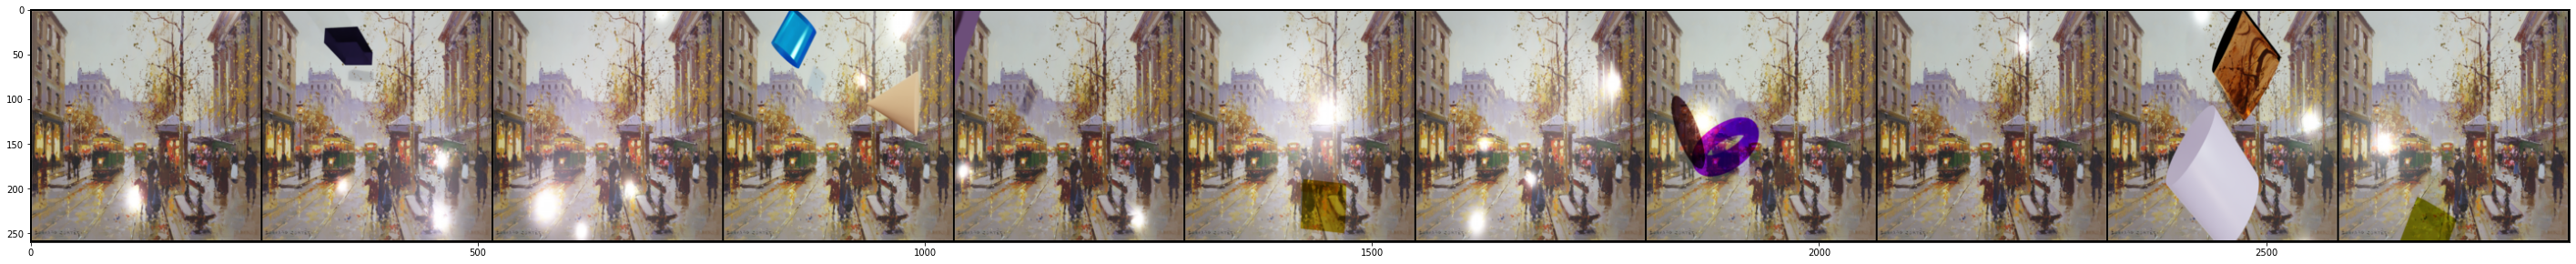

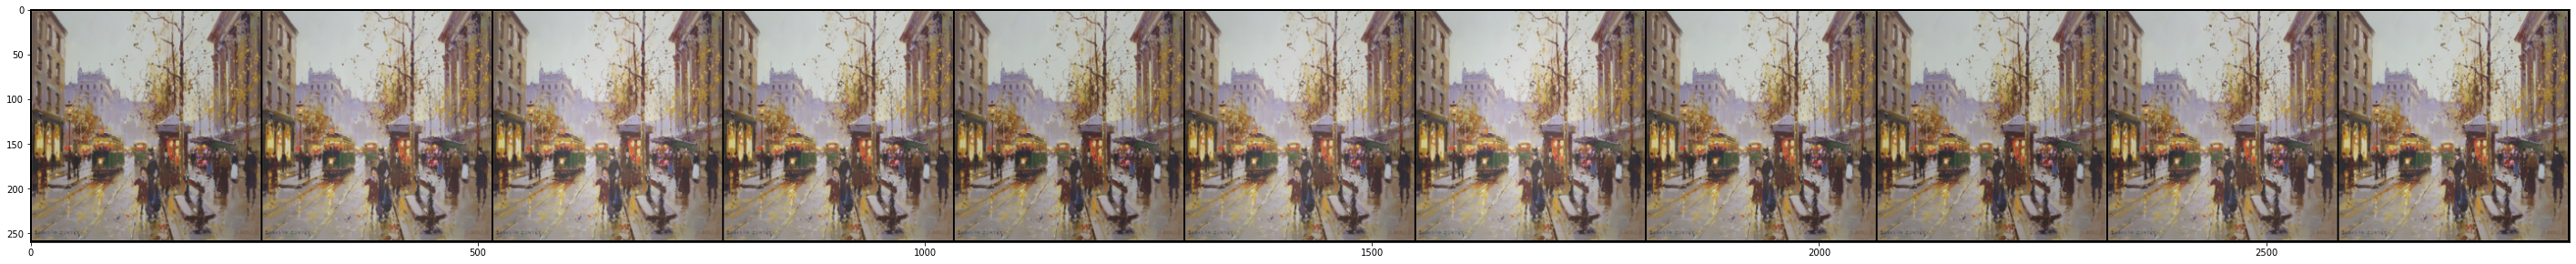

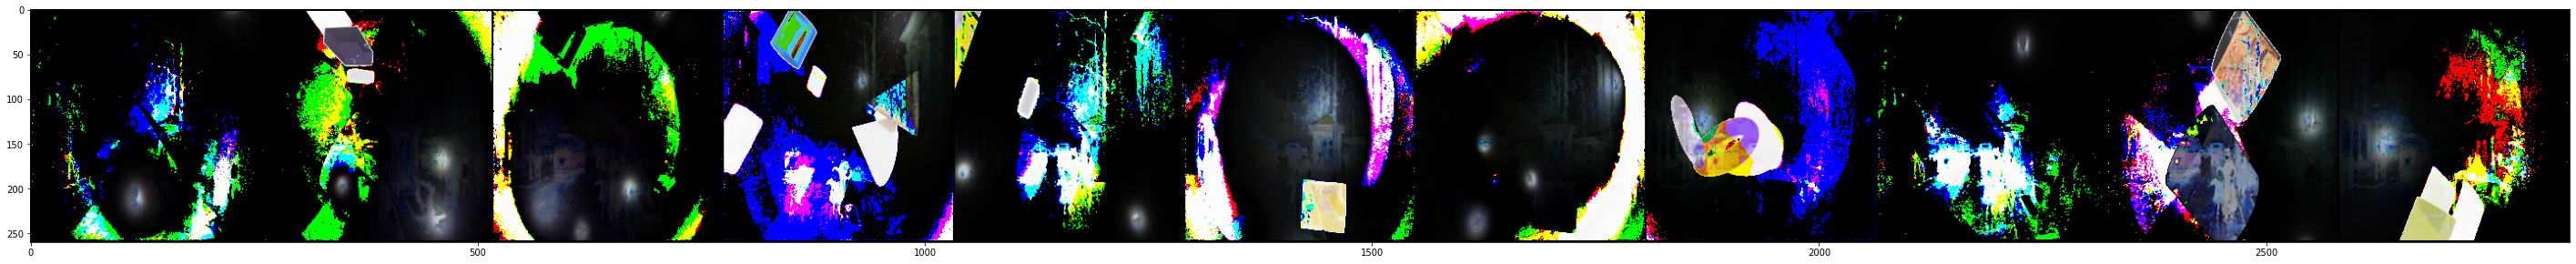

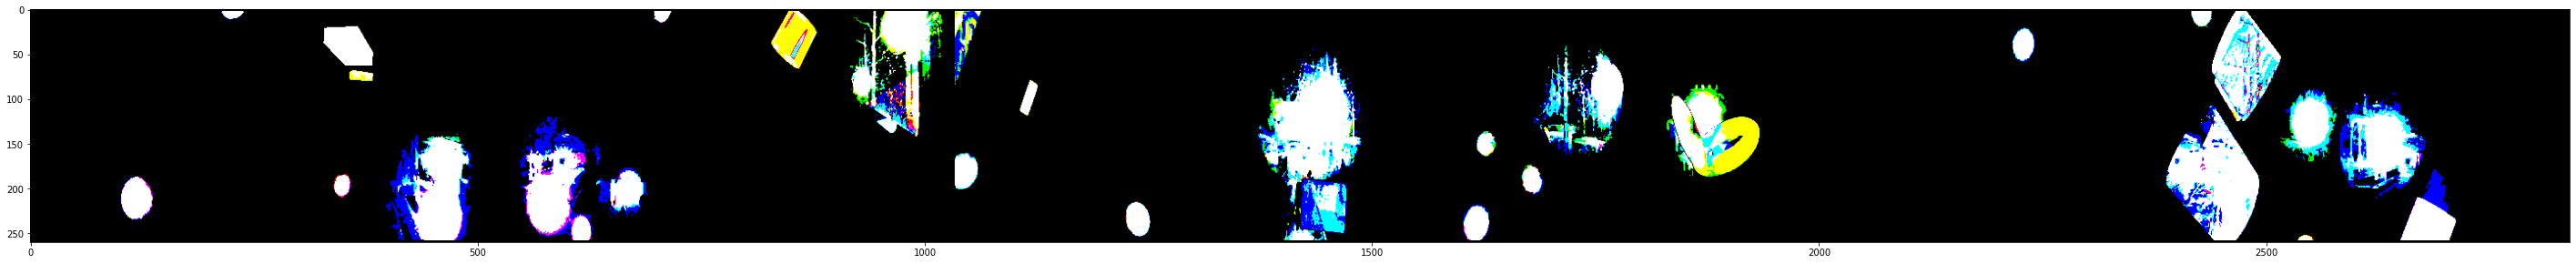

In [4]:
# visualize Low-Rank image
plt.figure(figsize=(50,5))
plt.imshow(to_pil_image(make_grid(imgs,nrow=11)))
plt.show()

# visualize Low-Rank image
plt.figure(figsize=(50,5))
plt.imshow(to_pil_image(make_grid(L,nrow=11)))
plt.show()

# visualize Sparse Image
plt.figure(figsize=(50,5))
plt.imshow(to_pil_image(make_grid(Sp,nrow=11)))
plt.show()

# Threshold image
thresh = 0.1
mask = (torch.abs(Sp) > thresh) +0.0

# visualize mask
plt.figure(figsize=(50,5))
plt.imshow(to_pil_image(make_grid(mask.squeeze(),nrow=11)))
plt.show()